<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/08_model-compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [15]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(is_chapter8=True)

/content/nlp-with-transformers


In [16]:
from utils import *
setup_chapter()

Using transformers v4.13.0
Using datasets v1.16.1


# 효율적인 트랜스포머 구축

<img alt="Scaling BERT at Roblox" caption="How Roblox scaled BERT with knowledge distillation, dynamic padding, and weight quantization (photo courtesy of Roblox employees Quoc N. Le and Kip Kaehler)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_roblox.png?raw=1" id="roblox"/>

## 의도 탐지 예제

<img alt="Out of Scope Query" width="400" caption="Three exchanges between a human (right) and a text-based assistant (left) for personal finance (courtesy of Stefan Larson et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_oos.png?raw=1" id="oos"/> 

In [17]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

In [18]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

## 벤치마크 클래스 만들기

In [19]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        # 나중에 정의합니다
        pass    

    def compute_size(self):
        # 나중에 정의합니다
        pass

    def time_pipeline(self):
        # 나중에 정의합니다
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

In [20]:
from datasets import load_dataset

clinc = load_dataset("clinc_oos", "plus")

  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
sample = clinc["test"][42]
sample

{'intent': 133, 'text': 'transfer $100 from my checking to saving account'}

In [22]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [23]:
from datasets import load_metric 

accuracy_score = load_metric("accuracy")

In [24]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [25]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

In [26]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

In [27]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

레이턴시 (ms) - 116.156
레이턴시 (ms) - 113.274
레이턴시 (ms) - 110.801


In [28]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통게 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [29]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.16
평균 레이턴시 (ms) - 78.31 +\- 15.62
테스트 세트 정확도 - 0.867


## 지식 정제로 모델 크기 줄이기

### 미세 튜닝을 위한 지식 정제

<img alt="Soft Probabilities" caption="Comparison of a hard label that is one-hot encoded (left), softmax probabilities (middle), and softened class probabilities (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_soft-probs.png?raw=1" id="soft-probs"/> 

<img alt="Knowledge distillation" caption="The knowledge distillation process" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_kd.png?raw=1" id="kd"/> 

### 사전 훈련을 위한 지식 정제

### 지식 정제 트레이너 만들기

In [30]:
from transformers import TrainingArguments

class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

In [31]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False):
        outputs_stu = model(**inputs)
        # 스튜던트의 크로스 엔트로피 손실과 로짓을 추출합니다
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # 티처의 로짓을 추출합니다
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # 확률을 부드럽게하고 정제 손실을 계산합니다
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # 가중 평균된 스튜던트 손실을 반환합니다
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

### 좋은 스튜던트 초기화 선택하기

In [32]:
from transformers import AutoTokenizer

student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [33]:
from huggingface_hub import notebook_login

notebook_login()

In [34]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_score.compute(predictions=predictions, references=labels)

In [35]:
batch_size = 48

finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
    output_dir=finetuned_ckpt, evaluation_strategy = "epoch", 
    num_train_epochs=5, learning_rate=2e-5, 
    per_device_train_batch_size=batch_size, 
    per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01, 
    push_to_hub=True)

In [36]:
student_training_args.logging_steps = len(clinc_enc['train']) // batch_size
student_training_args.disable_tqdm = False
student_training_args.save_steps = 1e9
student_training_args.log_level = 40

In [37]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [38]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [39]:
from transformers import AutoConfig

num_labels = intents.num_classes
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels, 
                                   id2label=id2label, label2id=label2id))

In [40]:
import torch
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [41]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [42]:
distilbert_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distilbert_trainer.train()

/content/nlp-with-transformers/distilbert-base-uncased-finetuned-clinc is already a clone of https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc. Make sure you pull the latest changes with `repo.git_pull()`.


Epoch,Training Loss,Validation Loss,Accuracy
1,4.289600,3.289124,0.742903
2,2.628300,1.875530,0.837419
3,1.548100,1.157003,0.896129
4,1.014900,0.857284,0.913226
5,0.795200,0.772014,0.918387


TrainOutput(global_step=1590, training_loss=2.0513538282622332, metrics={'train_runtime': 294.7589, 'train_samples_per_second': 258.686, 'train_steps_per_second': 5.394, 'total_flos': 413896353421488.0, 'train_loss': 2.0513538282622332, 'epoch': 5.0})

In [43]:
distilbert_trainer.push_to_hub("Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/256M [00:00<?, ?B/s]

Upload file runs/Aug09_06-03-19_cb6f1501ac1a/events.out.tfevents.1660025694.cb6f1501ac1a.71.2:  32%|###1      …

Upload file runs/Aug09_06-03-19_cb6f1501ac1a/1660025694.9731698/events.out.tfevents.1660025694.cb6f1501ac1a.71…

Upload file runs/Aug09_06-03-19_cb6f1501ac1a/events.out.tfevents.1660025667.cb6f1501ac1a.71.0:  32%|###1      …

Upload file runs/Aug09_06-28-42_cb6f1501ac1a/1660026530.491574/events.out.tfevents.1660026530.cb6f1501ac1a.543…

Upload file runs/Aug09_06-28-42_cb6f1501ac1a/events.out.tfevents.1660026530.cb6f1501ac1a.543.0:  25%|##5      …

Upload file training_args.bin: 100%|##########| 2.92k/2.92k [00:00<?, ?B/s]

To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc
   6bc1335..a3bb303  main -> main

To https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc
   a3bb303..c5c5e28  main -> main



'https://huggingface.co/haesun/distilbert-base-uncased-finetuned-clinc/commit/a3bb3037e0ebad5012384336c5c00004c0256089'

In [44]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
finetuned_ckpt = "haesun/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

Downloading:   0%|          | 0.00/8.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [45]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

모델 크기 (MB) - 255.89
평균 레이턴시 (ms) - 36.60 +\- 1.76
테스트 세트 정확도 - 0.858


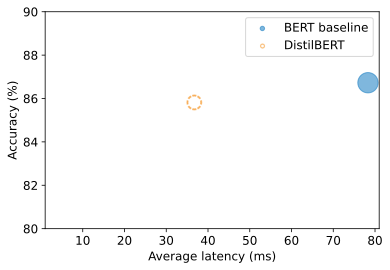

In [46]:
import pandas as pd

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # 현재 최적화 방법을 점선으로 그립니다
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        alpha=0.5, s=df_opt["size_mb"], label=idx, 
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, 
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
            
    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legendHandles:
        handle.set_sizes([20])

    plt.ylim(80,90)
    # 가장 느린 모델을 사용해 x 축 범위를 정합니다
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()
    
plot_metrics(perf_metrics, optim_type)

### 옵투나로 좋은 하이퍼파라미터 찾기

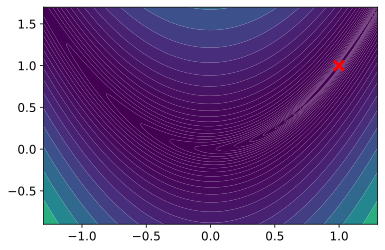

In [47]:
# 두 변수를 가진 로젠브록 함수 그래프
import matplotlib.pyplot as plt
import numpy as np

def f(x, y):
    return (1-x)**2+100*(y-x**2)**2
    
X, Y = np.meshgrid(np.linspace(-2, 2, 250), np.linspace(-1, 3, 250))
Z = f(X,Y)
_, ax = plt.subplots()
ax.plot([1], [1], 'x', mew=3, markersize=10, color="red")
ax.contourf(X, Y, Z, np.logspace(-1, 3, 30), cmap='viridis', extend="both")
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-0.9, 1.7)
plt.show()

In [48]:
def objective(trial):
    x = trial.suggest_float("x", -2, 2)
    y = trial.suggest_float("y", -2, 2)
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [49]:
import optuna 

study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2022-08-09 06:43:17,354] A new study created in memory with name: no-name-2350e156-05d2-4f43-9995-cd3ecee9fdbd
[I 2022-08-09 06:43:17,359] Trial 0 finished with value: 2770.0795124411316 and parameters: {'x': 1.8350864732665197, 'y': -1.894949576742849}. Best is trial 0 with value: 2770.0795124411316.
[I 2022-08-09 06:43:17,365] Trial 1 finished with value: 97.83964698958152 and parameters: {'x': 0.2527147848505624, 'y': 1.0501771460441938}. Best is trial 1 with value: 97.83964698958152.
[I 2022-08-09 06:43:17,367] Trial 2 finished with value: 245.7140220264541 and parameters: {'x': -0.11384616618518528, 'y': 1.5765253669825294}. Best is trial 1 with value: 97.83964698958152.
[I 2022-08-09 06:43:17,371] Trial 3 finished with value: 470.3543871104155 and parameters: {'x': -0.6906894148992451, 'y': -1.6851136124291881}. Best is trial 1 with value: 97.83964698958152.
[I 2022-08-09 06:43:17,374] Trial 4 finished with value: 48.68176060696785 and parameters: {'x': 0.13870098307709355, 'y

In [50]:
study.best_params

{'x': 0.9561024827261615, 'y': 0.9113062032385306}

In [51]:
def hp_space(trial):
    return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0, 1),
        "temperature": trial.suggest_int("temperature", 2, 20)}

In [52]:
best_run = distilbert_trainer.hyperparameter_search(
    n_trials=20, direction="maximize", hp_space=hp_space)

[I 2022-08-09 06:43:34,346] A new study created in memory with name: no-name-21422092-c0f6-4cfa-bde0-c7daae8e1515


Epoch,Training Loss,Validation Loss,Accuracy
1,0.410600,0.214143,0.594194
2,0.180200,0.107111,0.819032
3,0.113900,0.073040,0.877419
4,0.088600,0.058273,0.897419
5,0.076200,0.051161,0.907419
6,0.070900,0.049017,0.904194


[I 2022-08-09 06:49:33,310] Trial 0 finished with value: 0.9041935483870968 and parameters: {'num_train_epochs': 6, 'alpha': 0.2003080497002413, 'temperature': 9}. Best is trial 0 with value: 0.9041935483870968.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.388400,0.199304,0.591613
2,0.166800,0.097818,0.828065
3,0.103800,0.065299,0.884194
4,0.078900,0.050633,0.900645
5,0.065700,0.042498,0.909677
6,0.058400,0.038058,0.915484
7,0.053900,0.035644,0.915806
8,0.051700,0.034813,0.918065


[I 2022-08-09 06:57:29,730] Trial 1 finished with value: 0.9180645161290323 and parameters: {'num_train_epochs': 8, 'alpha': 0.01692907003706623, 'temperature': 15}. Best is trial 1 with value: 0.9180645161290323.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.417700,0.218009,0.597097
2,0.183200,0.108460,0.819032
3,0.115300,0.073562,0.878710
4,0.089400,0.058522,0.897097
5,0.076700,0.051293,0.906129
6,0.071300,0.049122,0.903548


[I 2022-08-09 07:03:29,148] Trial 2 finished with value: 0.9035483870967742 and parameters: {'num_train_epochs': 6, 'alpha': 0.6650986153496898, 'temperature': 8}. Best is trial 1 with value: 0.9180645161290323.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.396200,0.209088,0.575484
2,0.177800,0.108776,0.804839
3,0.116300,0.077570,0.868065
4,0.093800,0.064996,0.887742
5,0.084400,0.061104,0.894194


[I 2022-08-09 07:08:27,708] Trial 3 finished with value: 0.8941935483870967 and parameters: {'num_train_epochs': 5, 'alpha': 0.6721093357894988, 'temperature': 13}. Best is trial 1 with value: 0.9180645161290323.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.387300,0.196851,0.598065
2,0.164000,0.094734,0.832258
3,0.100500,0.062138,0.888065
4,0.075300,0.047354,0.901935
5,0.061500,0.038902,0.912581
6,0.053700,0.034104,0.919677
7,0.048400,0.031063,0.921290
8,0.045100,0.029154,0.924839
9,0.043000,0.028012,0.924839
10,0.042000,0.027665,0.923871


[I 2022-08-09 07:18:26,385] Trial 4 finished with value: 0.9238709677419354 and parameters: {'num_train_epochs': 10, 'alpha': 0.09799409098693013, 'temperature': 15}. Best is trial 4 with value: 0.9238709677419354.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.385900,0.203464,0.567097


[I 2022-08-09 07:19:27,587] Trial 5 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.438300,0.224347,0.617742


KeyboardInterrupt: ignored

In [ ]:
print(best_run)

In [ ]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)
    
# 정제된 모델을 저장할 새로운 저장소를 정의합니다
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt

# 최적의 매개변수로 새로운 Trainer를 만듭니다
distil_trainer = DistillationTrainer(model_init=student_init,
    teacher_model=teacher_model, args=student_training_args,
    train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics, tokenizer=student_tokenizer)

distil_trainer.train();

In [ ]:
distil_trainer.push_to_hub("Training complete")

### 정제 모델 벤치마크 수행하기

In [ ]:
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
distilled_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

## 양자화로 모델 속도 높이기

### 사이드바: 부동 소수점 숫자 vs 고정 소수점 숫자

### End sidebar

<img alt="Mapping floating-point numbers to 8-bit integers" width="800" caption="Quantizing floating-point numbers as unsigned 8-bit integers (courtesy of Manas Sahni)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_fp32-to-int8.png?raw=1" id="fp32toint8"/>

In [ ]:
import matplotlib.pyplot as plt

state_dict = pipe.model.state_dict()
weights = state_dict["distilbert.transformer.layer.0.attention.out_lin.weight"]
plt.hist(weights.flatten().numpy(), bins=250, range=(-0.3,0.3), edgecolor="C0")
plt.show()

In [ ]:
zero_point = 0
scale = (weights.max() - weights.min()) / (127 - (-128))

In [ ]:
(weights / scale + zero_point).clamp(-128, 127).round().char()

In [ ]:
from torch import quantize_per_tensor

dtype = torch.qint8
quantized_weights = quantize_per_tensor(weights, scale, zero_point, dtype)
quantized_weights.int_repr()

In [ ]:
# 트랜스포머 가중치에서 양자화 효과
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# 히스토그램 그리기
fig, ax = plt.subplots()
ax.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3), edgecolor="C0");
# 확대 그림 만들기
axins = zoomed_inset_axes(ax, 5, loc='upper right')
axins.hist(quantized_weights.dequantize().flatten().numpy(), 
         bins=250, range=(-0.3,0.3));
x1, x2, y1, y2 = 0.05, 0.1, 500, 2500
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.axes.xaxis.set_visible(False)
axins.axes.yaxis.set_visible(False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.show()

In [ ]:
%%timeit 
weights @ weights

In [ ]:
from torch.nn.quantized import QFunctional

q_fn = QFunctional()

In [ ]:
%%timeit
q_fn.mul(quantized_weights, quantized_weights)

In [ ]:
import sys

sys.getsizeof(weights.storage()) / sys.getsizeof(quantized_weights.storage())

In [ ]:
from torch.quantization import quantize_dynamic

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

### 양자화된 모델의 벤치마크 수행하기

In [ ]:
pipe = pipeline("text-classification", model=model_quantized, 
                tokenizer=tokenizer)
optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

## ONNX와 ONNX 런타임으로 추론 최적화하기

<img alt="Example ONNX graph" width="500" caption="A section of the ONNX graph for BERT-base, visualized in Netron" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_bert-onnx.png?raw=1" id="bert-onnx"/>

<img alt="Architecture of the ONNX and ONNX Runtime ecosystem" width="500" caption="Architecture of the ONNX and ONNX Runtime ecosystem (courtesy of the ONNX Runtime team)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_onnx-ort.png?raw=1" id="onnx-ort"/>

In [ ]:
import os
from psutil import cpu_count

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

In [ ]:
from transformers.convert_graph_to_onnx import convert

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_ckpt = "haesun/distilbert-base-uncased-distilled-clinc"
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, 
        output=onnx_model_path, opset=12, pipeline_name="text-classification")

In [ ]:
from onnxruntime import (GraphOptimizationLevel, InferenceSession, 
                         SessionOptions)

def create_model_for_provider(model_path, provider="CPUExecutionProvider"): 
    options = SessionOptions()
    options.intra_op_num_threads = 1
    options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL
    session = InferenceSession(str(model_path), options, providers=[provider])
    session.disable_fallback()
    return session

In [ ]:
onnx_model = create_model_for_provider(onnx_model_path)

In [ ]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]
logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

In [ ]:
np.argmax(logits_onnx)

In [ ]:
clinc_enc["test"][0]["labels"]

In [ ]:
from scipy.special import softmax

class OnnxPipeline:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        
    def __call__(self, query):
        model_inputs = self.tokenizer(query, return_tensors="pt")
        inputs_onnx = {k: v.cpu().detach().numpy() 
                       for k, v in model_inputs.items()}
        logits = self.model.run(None, inputs_onnx)[0][0, :]
        probs = softmax(logits)
        pred_idx = np.argmax(probs).item()
        return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

In [ ]:
pipe = OnnxPipeline(onnx_model, tokenizer)
pipe(query)

In [ ]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
    def __init__(self, *args, model_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        
    def compute_size(self):
        size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
        print(f"모델 크기 (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

In [ ]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type,
                              model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

In [ ]:
from onnxruntime.quantization import quantize_dynamic, QuantType

model_input = "onnx/model.onnx"
model_output = "onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)

In [ ]:
onnx_quantized_model = create_model_for_provider(model_output)
pipe = OnnxPipeline(onnx_quantized_model, tokenizer)
optim_type = "Distillation + ORT (quantized)"
pb = OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, 
                              model_path=model_output)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

## 가중치 가지치기로 희소한 모델 만들기

### 심층 신경망의 희소성

<img alt="Network Pruning" width="500" caption="Weights and neurons before and after pruning (courtesy of Song Han)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_network-pruning.png?raw=1" id="network-pruning"/> 

### 가중치 가지치기 방법

#### 절댓값 가지치기

In [ ]:
# 가지치기에 사용되는 세제곱 희소성 스케줄러
import numpy as np
import matplotlib.pyplot as plt

def _sparsity(t, t_0=0, dt=1, s_i=0, s_f=0.9, N=100):
    return s_f + (s_i - s_f) * (1 - (t - t_0) / (N * dt))**3

steps = np.linspace(0,100,100)
values = [_sparsity(t) for t in steps]

fig, ax = plt.subplots()
ax.plot(steps, values)
ax.set_ylim(0,1)
ax.set_xlim(0,100)
ax.set_xlabel("Pruning step")
ax.set_ylabel("Sparsity")
plt.grid(linestyle="dashed")
plt.show()

#### 이동 가지치기

<img alt="Magnitude vs Movement Pruning" width="700" caption="Comparison of weights removed (in gray) during magnitude pruning (left) and movement pruning (right)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_magnitude-vs-movement.png?raw=1" id="magnitude-vs-movement"/> 

<img alt="Pruning Distributions" width="500" caption="Distribution of remaining weights for magnitude pruning (MaP) and movement pruning (MvP)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pruning-dists.png?raw=1" id="pruning-dists"/>

## 결론